#LAB 4: Semantic segmentation

<h4><div style="text-align: right"> Due date: 15:00 Nov 18, 2024.  </div> <br>
<div style="text-align: right"> Please upload your file and final-report at PLATO before the class in the form of [ID_Name_Lab1.ipynb]. </div></h4>


### *Instructions:*
- Write a program implementing a particular algorithm to solve a given problem.   
- <span style="color:red">**Report and discuss your results. Analyze the algorithm, theoretically and empirically.**</span>
- You must write their own answers and codes (<span style="color:red">**if not you will get a F grade**</span>).


<h2><span style="color:blue">[202255665] [송승우]</span> </h2>

In [1]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2024-11-17 20:31:33.071043


In [1]:
import cv2
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.models as models




## Introduction


### What is Semantic Segmentation?
#### Semantic segmentation is an approach to understand what is in the image in pixel-level:

- It is a lot more difficult than image classification, which makes a prediction in image-level.

- It differs from object detection in that it has no information about instances.

<img src="https://drive.google.com/uc?export=view&id=1Oe6OVIuT8WPxK4x0LXOunxL-tVtzg948" alt="no_image" style="width: 900px;"/>

Applications for semantic segmentation include:

- Autonomous driving

- Image Editing

- Classification of terrain visible in satellite imagery

- Medical imaging analysis

### 1. Semantic segmentation with CNNs
- Typical classification models (AlexNet, VGGNet, ...) take fixed-sized inputs and produce a probability vector. The fully connected layers of these models have fixed dimensions and throw away spatial coordinates.


- It is known that the fully connected layer can be viewed as a convolution layer with a kernel that covers only one pixel, that is, a 1x1 kernel. Thus, we can convert the fully connected layers into convolution layers with maintaining pre-trained weights.


- After 'convolutionalizing' fully connected layers, a feature map needs to be upsampled because of pooling operations in the models. Instead of using simple bilinear interpolation, we can use a transposed convolution layer to learn the interpolation process. This layer is also called as upconvolution, deconvolution or fractionally-strided convolution.

### 1.1 Pixel wise classification using sliding window

<img src="https://drive.google.com/uc?export=view&id=1RJOmD22NyRT-6T0hCQ5hbU3FB9Mpevyu" alt="no_image" style="width: 900px;"/>

### 1.1.1 Example with VGG-Net

**Load a test image**

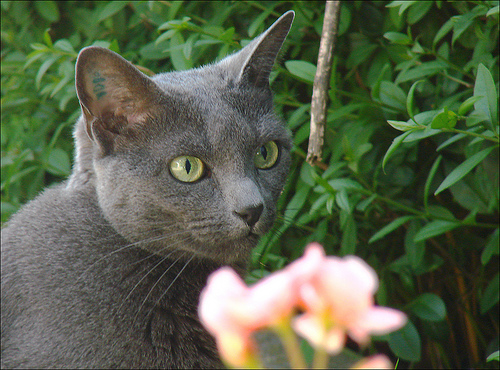

In [2]:
from PIL import Image
test_img_path = '../lab4/img/2009_005160.jpg'
test_img = Image.open(test_img_path)
test_img

**Standardization of the test image**

In [4]:
import torchvision.transforms as transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

test_transform = transform(test_img).cuda().unsqueeze(0)
print(test_transform.size())

torch.Size([1, 3, 224, 224])


**Load VGG-Net**

In [5]:
import torchvision.models.vgg as vgg
imageNet = vgg.vgg16(weights=True).cuda()

/home/team103/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
import torch
import torch.nn as nn
with torch.no_grad():
    out = imageNet(test_transform)

out_class = torch.argmax(out)
print(out.size())
print(out_class) # 285 is egyptian cat in ImageNet

torch.Size([1, 1000])
tensor(285, device='cuda:0')


In [7]:
# padding
m = nn.ZeroPad2d((111,112,111,112))
pad_image = m(test_transform)
res = torch.zeros((224,224)).cuda()

In [8]:
# sliding window approach for segmentation
# NOTICE: It takes some time
for i in range(224):
    for j in range(224):
        patch = pad_image[:,:,i:i+224,j:j+224]
        # classify each pixels
        with torch.no_grad():
            res[i,j] = torch.argmax(imageNet(patch))

In [9]:
print(res)

tensor([[285., 285., 285.,  ..., 282., 281., 285.],
        [285., 285., 285.,  ..., 285., 285., 285.],
        [285., 285., 285.,  ..., 281.,  24., 285.],
        ...,
        [285., 285., 360.,  ..., 254., 254., 254.],
        [285., 286., 286.,  ..., 174., 254.,  87.],
        [285., 360., 285.,  ..., 254., 254., 254.]], device='cuda:0')


**Visualize the output, classified as 'egyptian cat' (285)**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


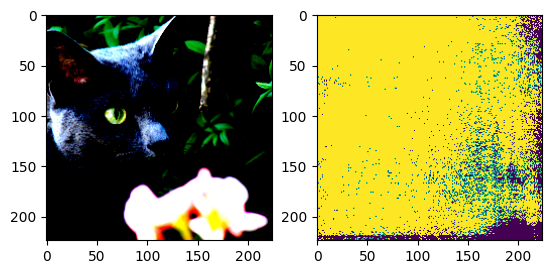

In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplot(1,2,1)
plt.imshow(test_transform[0].data.cpu().numpy().transpose((1,2,0)))
plt.subplot(1,2,2)
plt.imshow((res==285).data.cpu().numpy()) # Visualize pixels classified as egyptian cat
plt.show()

- Inefficient & Ineffective !

### 1.2 Pixel wise classification using image classification

<img src="https://drive.google.com/uc?export=view&id=1XaspEEpplLzpNJ8qJpPN24qMeVmbsp5P" alt="no_image" style="width: 900px;"/>

#### 1.2.1 Convolutional VGG

In [11]:
import torchvision.models as models

class ConvolutionalVGG(nn.Module):
    def __init__(self):
        super(ConvolutionalVGG, self).__init__()
        self.features = models.vgg16(pretrained=True).features

        # fc6
        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()

        # fc7
        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()

        # fc8
        self.fc8 = nn.Conv2d(4096, 1000, 1)

        self.copy_params_from_vgg16()

    def forward(self, x):
        conv5 = self.features(x)

        fc6 = self.relu6(self.fc6(conv5))
        fc7 = self.drop6(fc6)

        fc7 = self.relu7(self.fc7(fc7))
        fc8 = self.drop7(fc7)

        score = self.fc8(fc8)

        return score

    def copy_params_from_vgg16(self):
        vgg16 = models.vgg16(pretrained=True)
        for i, name in zip([0, 3, 6], ['fc6', 'fc7', 'fc8']):
            l1 = vgg16.classifier[i]
            l2 = getattr(self, name)
            l2.weight.data.copy_(l1.weight.data.view(l2.weight.size()))
            l2.bias.data.copy_(l1.bias.data.view(l2.bias.size()))

In [12]:
conv_vgg = ConvolutionalVGG().cuda()
conv_vgg

/home/team103/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(


ConvolutionalVGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=

In [13]:
transform_conv = transforms.Compose([
    transforms.ToTensor(),
    normalize,
])

In [14]:
test_conv = transform_conv(test_img).cuda().unsqueeze(0)
print(test_conv.size())

torch.Size([1, 3, 370, 500])


In [15]:
conv_out = conv_vgg(test_conv)
pred = torch.argmax(conv_out, dim=1)
pred

tensor([[[284, 284, 284, 284, 284, 284, 284, 284, 282],
         [284, 284, 284, 284, 284, 284, 284, 284, 281],
         [284, 284, 284, 285, 285, 285, 285, 284, 285],
         [285, 285, 285, 285, 285, 284, 852, 284, 285],
         [285, 285, 285, 285, 285, 285, 281, 281, 285]]], device='cuda:0')

Well...

Although modifying VGG-Net to fully convolutional network results in a pixel-wise ouput, the output resolution is smaller than the original image resolution. Moreover, we can see that many pixels are misclassified (i.e., not 285).

#### 1.2.2 Add simple upsampling layer (Bilinear) and retrain with PASCAL VOC 2012  [1 point]
- Re-define the last layer so as to classify classes in the PASCAL VOC datasets
- Use bilinear interpolation to make the network output equal to the input size

In [16]:
import torchvision.models as models

class ConvolutionalVGGwithUpsample(nn.Module):
    def __init__(self):
        super(ConvolutionalVGGwithUpsample, self).__init__()
        self.features = models.vgg16(pretrained=True).features
        self.features[0].padding = (100,100)

        # fc6
        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()

        # fc7
        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()

        # fc8
        self.fc8 = nn.Conv2d(4096, 21, 1)

        self.copy_params_from_vgg16()


    def forward(self, x):
        conv5 = self.features(x)

        fc6 = self.relu6(self.fc6(conv5))
        fc7 = self.drop6(fc6)

        fc7 = self.relu7(self.fc7(fc7))
        fc8 = self.drop7(fc7)

        score = self.fc8(fc8)

        # Upsample to original resolution
        score = nn.functional.interpolate(score, scale_factor=32,mode='bilinear', align_corners=True)
        
        return score

    def copy_params_from_vgg16(self):
        vgg16 = models.vgg16(pretrained=True)
        for i, name in zip([0, 3], ['fc6', 'fc7']):
            l1 = vgg16.classifier[i]
            l2 = getattr(self, name)
            l2.weight.data.copy_(l1.weight.data.view(l2.weight.size()))
            l2.bias.data.copy_(l1.bias.data.view(l2.bias.size()))

In [17]:
conv_vgg_upsample = ConvolutionalVGGwithUpsample().cuda()

In [16]:
def decode_labels(mask, num_classes=21):
    from PIL import Image
    label_colours = [(0, 0, 0)
                 # 0=background
                 , (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128)
                 # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
                 , (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0)
                 # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
                 , (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128)
                 # 11=diningtable, 12=dog, 13=horse, 14=motorbike, 15=person
                 , (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)]
                 # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor

    h, w = mask.shape

    img = Image.new('RGB', (w, h))
    pixels = img.load()
    for j_, j in enumerate(mask[:, :]):
        for k_, k in enumerate(j):
            if k < num_classes:
                pixels[k_, j_] = label_colours[k]
    output = np.array(img)

    return output

In [19]:
model_data = torch.load('../lab5/vgg_conv_upsample.pth')
conv_vgg_upsample.load_state_dict(model_data)

<All keys matched successfully>

In [20]:
with torch.no_grad():
    conv_out = conv_vgg_upsample(test_conv)
output = torch.argmax(conv_out, dim=1)

vis_output = decode_labels(output[0].data.cpu().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


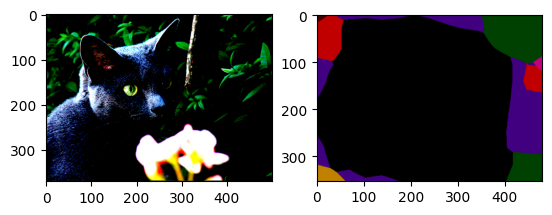

In [21]:
plt.subplot(1,2,1)
plt.imshow(test_conv[0].data.cpu().numpy().transpose((1,2,0)))
plt.subplot(1,2,2)
plt.imshow(vis_output)

### 1.3 Upsampling method with CNNs

#### 1.3.1 Transposed Convolution

<img src="https://drive.google.com/uc?export=view&id=1olTrk2Hu1dAppF2zxFVedy0aIrAbYrAw"  onerror="this.style.display='none'" /><br><br>

- The transposed convolution (it is often called as "deconvolution") is used to up-sample the input resolution by using learnable filters. In contrast to the standard convolution, which aggregates spatial information to a single point, it spreads a point of the input over multiple spatial locations.
- For example, a $3\times3$ kernel with a stride of 2 converts the~$2\times2$~(cyan squares) input into the~$5\times5$~(blue squares) output.

#### 1.3.2 Dilated Convolution
<img src="https://drive.google.com/uc?export=view&id=1LxBcf7V_s7559Odw9JzPwXFpPYCXa4JT"  onerror="this.style.display='none'" /><br><br>
- The dilated convolution introduces 'a dilation rate' to the standard convolution.

- The dilation rate means a spacing value between elements of a kernel, which enlarges the receptive field without introducing additional parameters.

- For example, a $3\times3$ kernel with a dilation rate of 2 has the same receptive field as a $5\times5$ kernel while it still use 9 parameters only, compared to the $5\times5$ the uses 25 parameters.

## 2. [Lab] Semantic segmentation

### 2.1 Write a FCN8s model  [4 points]

<img src="https://drive.google.com/uc?export=view&id=1xLdKvbMZrszjG2nVqFV3AsJ0t4M-nEN6"  onerror="this.style.display='none'" /><br><br>

<p style='text-align:right;'>[<a href='https://medium.com/@wilburdes/semantic-segmentation-using-fully-convolutional-neural-networks-86e45336f99b'>source</a>]</p>

**Crop boundary example**

In [22]:
a = torch.ones((1, 1, 160, 140))
b = torch.ones((1, 1, 120, 120))

try:
    a + b
except:
    print('The size of tensors are different')
    print(a.size())
    print(b.size())

# crop boundary
a = a[:, :, 5: 5+b.size(2), 5:5+b.size(3)]

# add connection with weight
c = 0.01*a + b

The size of tensors are different
torch.Size([1, 1, 160, 140])
torch.Size([1, 1, 120, 120])


- Predict 1: $1\times1$ Conv(in: 4096, out: n_class)
- Predict 2: $1\times1$ Conv(in: 512, out: n_class), weight = 0.01
- Predict 3: $1\times1$ Conv(in: 256, out: n_class), weight = 0.0001

- Deconv 1: $4\times4$ Transposed Conv (in: n_class, out: n_class, stride: 2, biase: False)
- Deconv 2: $4\times4$ Transposed Conv (in: n_class, out: n_class, stride: 2, biase: False)
- Deconv 3: $16\times16$ Transposed Conv (in: n_class, out: n_class, stride: 8, biase: False)

In [2]:
class FCN8s(nn.Module):
    def __init__(self, n_class=21):
        super(FCN8s, self).__init__()
        # VGG features
        self.features = models.vgg16(pretrained=True).features

        # fc6
        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()

        # fc7
        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()

        self.predict3 = nn.Conv2d(256, n_class, kernel_size=1)
        self.predict2 = nn.Conv2d(512, n_class, kernel_size=1)
        self.predict1 = nn.Conv2d(4096, n_class, kernel_size=1)

        self.deconv1 = nn.ConvTranspose2d(n_class, n_class, kernel_size=4, stride =2, bias=False)
        self.deconv2 = nn.ConvTranspose2d(n_class, n_class, kernel_size=4, stride =2, bias=False)
        self.deconv3 = nn.ConvTranspose2d(n_class, n_class, kernel_size=16, stride =8, bias=False)
        
        self._initialize_weights()
        self.copy_params_from_vgg16()

    def _initialize_weights(self):
        self.features[0].padding = (100,100)

        for m in self.modules():
            if isinstance(m, nn.MaxPool2d):
                m.ceil_mode=True
            if isinstance(m, nn.ConvTranspose2d):
                assert m.kernel_size[0] == m.kernel_size[1]
                initial_weight = get_upsampling_weight(
                    m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(initial_weight)

    def forward(self, x):
        pool3 = self.features[:17](x)
        pool4 = self.features[17:24](pool3)
        pool5 = self.features[24:](pool4)

        fc7 = self.drop7(self.relu7(self.fc7(self.drop6(self.relu6(self.fc6(pool5))))))        

        p1 = self.predict1(fc7)
        p2 = self.predict2(pool4) * 0.01
        p3 = self.predict3(pool3) * 0.0001

        d1 = self.deconv1(p1) #Deconv1
        p2 = p2[:, :, 5:5+d1.size(2), 5:5+d1.size(3)].contiguous()
        d2 = self.deconv2(d1 + p2) #Deconv2
        p3 = p3[:, :, 9:9+d2.size(2), 9:9+d2.size(3)].contiguous()
        d3 = self.deconv3(d2 + p3) #Deconv3
        d3 = d3[:, :, 28:28+x.size(2), 28:28+x.size(3)].contiguous()
        return d3

    def copy_params_from_vgg16(self):
        vgg16 = models.vgg16(pretrained=True)
        for i, name in zip([0, 3], ['fc6', 'fc7']):
            l1 = vgg16.classifier[i]
            l2 = getattr(self, name)
            l2.weight.data.copy_(l1.weight.data.view(l2.weight.size()))
            l2.bias.data.copy_(l1.bias.data.view(l2.bias.size()))

def get_upsampling_weight(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size),
                      dtype=np.float64)
    weight[range(in_channels), range(out_channels), :, :] = filt
    return torch.from_numpy(weight).float()

In [3]:
model = FCN8s().cuda()

/home/team103/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/team103/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


**Data Loader functions**

In [4]:
import random
import os

def read_file(path_to_file):
    with open(path_to_file) as f:
        img_list = []
        for line in f:
            img_list.append(line[:-1])
    return img_list

def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def flip(I, flip_p):
    if flip_p > 0.5:
        return np.fliplr(I)
    else:
        return I

def scale_im(img_temp, scale):
    new_dims = (int(img_temp.shape[0] * scale), int(img_temp.shape[1] * scale))
    return cv2.resize(img_temp, new_dims).astype(float)


def get_data(chunk, gt_path='../lab4/gt', img_path='../lab4/img'):
    assert len(chunk) == 1

    scale = random.uniform(0.5, 1.3)
    flip_p = random.uniform(0, 1)

    images = cv2.imread(os.path.join(img_path, chunk[0] + '.jpg')).astype(float)

    images = cv2.resize(images, (321, 321)).astype(float)
    images = scale_im(images, scale)
    images[:, :, 0] = images[:, :, 0] - 104.008
    images[:, :, 1] = images[:, :, 1] - 116.669
    images[:, :, 2] = images[:, :, 2] - 122.675
    images = flip(images, flip_p)
    images = images[:, :, :, np.newaxis]
    images = images.transpose((3, 2, 0, 1))
    images = torch.from_numpy(images.copy()).float()

    gt = cv2.imread(os.path.join(gt_path, chunk[0] + '.png'))[:, :, 0]
    gt[gt == 255] = 0
    gt = flip(gt, flip_p)

    dim = int(321 * scale)

    gt = cv2.resize(gt, (dim, dim), interpolation=cv2.INTER_NEAREST).astype(float)

    labels = torch.from_numpy(gt[np.newaxis, :].copy()).long()

    return images, labels

**Data load**

In [5]:
img_list = read_file('../lab4/list/train_aug.txt')
data_list = []

for i in range(10):
    np.random.shuffle(img_list)
    data_list.extend(img_list)
data_gen = chunker(data_list, 1)

In [6]:
lr = 0.00001

optimizer = optim.Adam(model.parameters(), lr=lr)
optimizer.zero_grad()
max_iter = 20000

### 2.2 Write train code and print loss [2 points]
- Use a cross-entropy loss.
- Print a training loss for every 100 iterations.
- Show that the training loss steadily decreases.

In [7]:
def loss_calc(out, label):
    criterion = nn.CrossEntropyLoss()
    loss = criterion(out, label)
    return loss

In [8]:
running_loss = 0.0

for iter in range(max_iter + 1):
    inputs, label = get_data(next(data_gen))
    inputs = inputs.cuda()
    label = label.cuda()
    
    optimizer.zero_grad()
    
    outputs = model(inputs)
    
    loss = loss_calc(outputs, label)

    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    if iter % 100 == 0:
        avg_loss = running_loss / 100
        print(f"Iteration {iter}/{max_iter}, Loss: {avg_loss:.4f}")
        running_loss = 0

Iteration 0/20000, Loss: 0.0755
Iteration 100/20000, Loss: 2.9209
Iteration 200/20000, Loss: 1.6842
Iteration 300/20000, Loss: 1.5246
Iteration 400/20000, Loss: 1.4268
Iteration 500/20000, Loss: 1.4541
Iteration 600/20000, Loss: 1.3046
Iteration 700/20000, Loss: 1.3286
Iteration 800/20000, Loss: 1.2498
Iteration 900/20000, Loss: 1.2450
Iteration 1000/20000, Loss: 1.2218
Iteration 1100/20000, Loss: 1.1328
Iteration 1200/20000, Loss: 1.0894
Iteration 1300/20000, Loss: 1.0225
Iteration 1400/20000, Loss: 1.0189
Iteration 1500/20000, Loss: 1.0439
Iteration 1600/20000, Loss: 1.1059
Iteration 1700/20000, Loss: 0.9488
Iteration 1800/20000, Loss: 0.8834
Iteration 1900/20000, Loss: 0.8683
Iteration 2000/20000, Loss: 0.9825
Iteration 2100/20000, Loss: 1.1063
Iteration 2200/20000, Loss: 0.8913
Iteration 2300/20000, Loss: 0.9974
Iteration 2400/20000, Loss: 0.8529
Iteration 2500/20000, Loss: 0.8844
Iteration 2600/20000, Loss: 0.8194
Iteration 2700/20000, Loss: 0.8455
Iteration 2800/20000, Loss: 0.83

### 2.3 Discuss the result [3 points]
- Compare and Discuss the results. Note that it must contain the quantitative and qualitative results.
- Use the below 'validation_miou' function to evaluate your model. Your model should perform better than the example model **(0.5 mIoU)**.
- Use the above 'decode_label' function to visualize the network output.

In [13]:
def validation_miou(model):
    max_label = 20
    hist = np.zeros((max_label + 1, max_label + 1))

    def fast_hist(a, b, n):
        k = (a >= 0) & (a < n)
        return np.bincount(n * a[k].astype(int) + b[k], minlength=n ** 2).reshape(n, n)

    val_list = open('../lab4/list/val.txt').readlines()

    with torch.no_grad():
        for idx, i in enumerate(val_list):
            print('{}/{} ...'.format(idx + 1, len(val_list)))

            img = cv2.imread(os.path.join('../lab4/img', i[:-1] + '.jpg')).astype(float)

            img[:, :, 0] -= 104.008
            img[:, :, 1] -= 116.669
            img[:, :, 2] -= 122.675

            data = torch.from_numpy(img.transpose((2,0,1))).float().cuda().unsqueeze(0)
            score = model(data)

            output = score.cpu().data[0].numpy().transpose(1, 2, 0)
            output = np.argmax(output, axis=2)
            gt = cv2.imread(os.path.join('../lab4/gt', i[:-1] + '.png'), 0)

            hist += fast_hist(gt.flatten(), output.flatten(), max_label + 1)

        miou = np.diag(hist) / (hist.sum(1) + hist.sum(0) - np.diag(hist))
        print("Mean iou = ", np.sum(miou) / len(miou))

    return np.sum(miou) / len(miou)

In [14]:
validation_miou(model)

1/1449 ...
2/1449 ...
3/1449 ...
4/1449 ...
5/1449 ...
6/1449 ...
7/1449 ...
8/1449 ...
9/1449 ...
10/1449 ...
11/1449 ...
12/1449 ...
13/1449 ...
14/1449 ...
15/1449 ...
16/1449 ...
17/1449 ...
18/1449 ...
19/1449 ...
20/1449 ...
21/1449 ...
22/1449 ...
23/1449 ...
24/1449 ...
25/1449 ...
26/1449 ...
27/1449 ...
28/1449 ...
29/1449 ...
30/1449 ...
31/1449 ...
32/1449 ...
33/1449 ...
34/1449 ...
35/1449 ...
36/1449 ...
37/1449 ...
38/1449 ...
39/1449 ...
40/1449 ...
41/1449 ...
42/1449 ...
43/1449 ...
44/1449 ...
45/1449 ...
46/1449 ...
47/1449 ...
48/1449 ...
49/1449 ...
50/1449 ...
51/1449 ...
52/1449 ...
53/1449 ...
54/1449 ...
55/1449 ...
56/1449 ...
57/1449 ...
58/1449 ...
59/1449 ...
60/1449 ...
61/1449 ...
62/1449 ...
63/1449 ...
64/1449 ...
65/1449 ...
66/1449 ...
67/1449 ...
68/1449 ...
69/1449 ...
70/1449 ...
71/1449 ...
72/1449 ...
73/1449 ...
74/1449 ...
75/1449 ...
76/1449 ...
77/1449 ...
78/1449 ...
79/1449 ...
80/1449 ...
81/1449 ...
82/1449 ...
83/1449 ...
84/1449 ...
8

0.460912399598246

In [20]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def visualize_model(model, image_path, num_classes=21):
    input_image = cv2.imread(image_path)
    input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

    normalized_image = input_image.astype(float)
    normalized_image[:, :, 0] -= 104.008
    normalized_image[:, :, 1] -= 116.669
    normalized_image[:, :, 2] -= 122.675
    input_tensor = torch.from_numpy(normalized_image.transpose(2, 0, 1)).float().unsqueeze(0).cuda()

    model.eval()
    with torch.no_grad():
        output = model(input_tensor)

    predicted_output = output.cpu().data[0].numpy().transpose(1, 2, 0)
    predicted_output = np.argmax(predicted_output, axis=2)

    if gt_path:
        ground_truth = cv2.imread(gt_path, 0)
        decoded_gt = decode_labels(ground_truth, num_classes=num_classes)
    else:
        ground_truth = None
        decoded_gt = None

    decoded_prediction = decode_labels(predicted_output, num_classes=num_classes)

    fig, axs = plt.subplots(1, 3 if ground_truth is not None else 2, figsize=(15, 5))

    axs[0].imshow(input_image)
    axs[0].set_title("Input Image")
    axs[0].axis("off")

    if ground_truth is not None:
        axs[1].imshow(decoded_gt)
        axs[1].set_title("Ground Truth")
        axs[1].axis("off")

    axs[-1].imshow(decoded_prediction)
    axs[-1].set_title("Predicted Output")
    axs[-1].axis("off")

    plt.show()


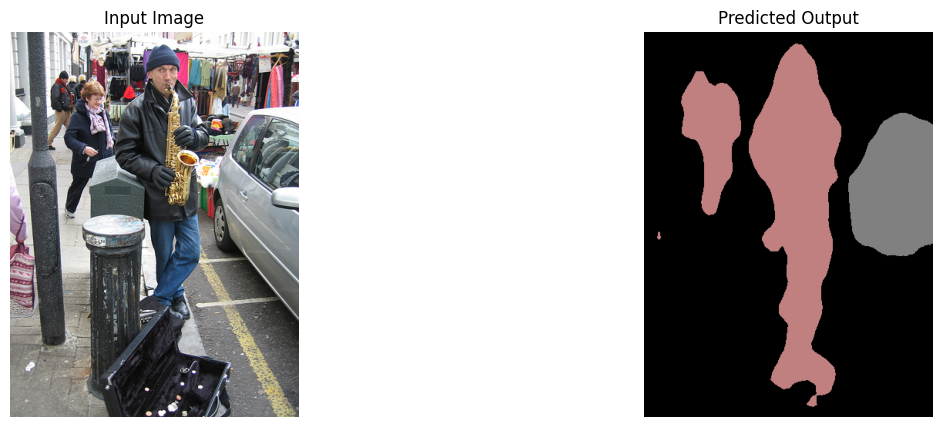

In [38]:
image_path = '../lab4/img/2010_006565.jpg'
visualize_model(model, image_path)

### *References*
[1] FCN official code (https://github.com/shelhamer/fcn.berkeleyvision.org)

[2] Upsampling method (https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d)

[3] Cs231n (http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture11.pdf)